In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift, estimate_bandwidth
from itertools import cycle
import ROI_actions
from ROI_actions import *
# Getting my modules
sys.path.append('/home/jonathak/VisualEncoder/Analysis/Brain_maps')
from NIPS_utils import get_hemisphere_indices, get_roi_indices, get_roi_indices_per_hemisphere


# Setting up GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Appending Roman's path
sys.path.append('/home/romanb/PycharmProjects/BrainVisualReconst/')

In [2]:
# Loading the model
encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
model = torch.load('/home/jonathak/VisualEncoder/Voxels_Prediction/model_ch128.pth').eval().cuda()

# Testing voxel embeddings
voxel_embeddings = model.voxel_embed # Has shape [315997, 256]

# Getting subject 1 indices

subject = 1

lh_start, lh_end = get_hemisphere_indices(subject, 'lh')
rh_start, rh_end = get_hemisphere_indices(subject, 'rh')    
sub_indices = np.arange(lh_start, rh_end)

voxel_embeddings = voxel_embeddings[sub_indices]


Using cache found in /home/matanyaw/.cache/torch/hub/facebookresearch_dinov2_main
/home/matanyaw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/matanyaw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/matanyaw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [3]:
# # Getting tSNE embeddings
# # ! note that I commented this out for a quick run
tsne = TSNE(n_components=2, random_state=42, perplexity=30, metric="correlation")
voxel_embeddings_tsne = tsne.fit_transform(voxel_embeddings.detach().squeeze().cpu().numpy())

/home/matanyaw/miniconda3/envs/amit-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/matanyaw/miniconda3/envs/amit-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [4]:
def plot_all_rois_tsne(voxel_embeddings_tsne, roi_index_dict, ROIs_to_plot, title="t-SNE of All ROI Embeddings", ROIless_indices=None):
    """
    Plots t-SNE embeddings of all provided ROIs with unique colors and labels.

    Parameters:
    - voxel_embeddings_tsne: [num_voxels, 2] numpy array of t-SNE embeddings.
    - roi_index_dict: Dictionary with ROI names as keys and arrays of voxel indices as values.
    """

    # Prepare colors
    cmap = cm.get_cmap('tab20', len(ROIs_to_plot))
    color_cycle = cycle([cmap(i) for i in range(cmap.N)])

    plt.figure(figsize=(10, 8))

    for roi_name in ROIs_to_plot:
        indices = roi_index_dict.get(roi_name)
        if indices is not None and len(indices) > 0:
            color = next(color_cycle)
            plt.scatter(voxel_embeddings_tsne[indices, 0],
                        voxel_embeddings_tsne[indices, 1],
                        label=f'{roi_name} ({len(indices)})',
                        alpha=0.6,
                        s=10,
                        color=color)
    if ROIless_indices is not None and len(ROIless_indices) > 0:

        plt.scatter(voxel_embeddings_tsne[ROIless_indices, 0],
                        voxel_embeddings_tsne[ROIless_indices, 1],
                        label=f'No-ROI Voxels ({len(ROIless_indices)})',
                        alpha=0.6,
                        s=10,
                        color='black')

    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [5]:
def plot_roi_intersection_tsne(roi1_indices, roi1_name, roi2_indices, roi2_name, voxel_embeddings_tsne):
    """
    Plots the t-SNE embeddings of two ROIs and their intersection.

    Parameters:
    - roi1_indices: Indices of the first ROI.
    - roi1_name: Name of the first ROI.
    - roi2_indices: Indices of the second ROI.
    - roi2_name: Name of the second ROI.
    - voxel_embeddings_tsne: t-SNE embeddings of the voxel embeddings.
    """
    plt.figure(figsize=(8, 6))

    intersection = np.intersect1d(roi1_indices, roi2_indices)
    roi1_only = np.setdiff1d(roi1_indices, intersection)
    roi2_only = np.setdiff1d(roi2_indices, intersection)

    # Plot first ROI
    plt.scatter(voxel_embeddings_tsne[roi1_only][:, 0], 
                voxel_embeddings_tsne[roi1_only][:, 1], 
                alpha=0.4, label=f'{roi1_name} ({len(roi1_indices)})', color='orange')

    # Plot second ROI
    plt.scatter(voxel_embeddings_tsne[roi2_only][:, 0], 
                voxel_embeddings_tsne[roi2_only][:, 1], 
                alpha=0.4, label=f'{roi2_name} ({len(roi2_indices)})', color='blue')

    # Highlight intersection
    if len(intersection) > 0:
        plt.scatter(voxel_embeddings_tsne[intersection][:, 0],
                    voxel_embeddings_tsne[intersection][:, 1],
                    alpha=1.0, color='green', label=f'Intersection ({len(intersection)})', s=10)

    plt.title(f't-SNE Intersection: {roi1_name} vs {roi2_name}', fontsize=14)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [6]:
def plot_ROI_overlap_heatmap_percentage(ROI_indices, title, ROIless_indices_amount=None):
    """
    Plots a heatmap where each cell[i, j] shows the percentage of ROI_i overlapping with ROI_j.
    Rows are ROI1, columns are ROI2.

    Parameters:
    - ROIs: list of ROI names
    - ROI_indices: dict mapping ROI name -> array of voxel indices
    - title: title for the plot
    """
     # ensure everything is a CPU numpy array
    for roi in ROI_indices:
        idx = ROI_indices[roi]
        if torch.is_tensor(idx):
            ROI_indices[roi] = idx.cpu().numpy()
    # Compute ROI sizes
    ROI_names = list(ROI_indices.keys())
    roi_sizes = {roi_name: len(ROI_indices[roi_name]) for roi_name in ROI_names}

    # Build overlap percentage matrix
    n = len(ROI_names)
    overlap_pct = np.zeros((n, n), dtype=float)
    for i, roi1 in enumerate(ROI_names):
        idx1 = ROI_indices[roi1]
        size1 = roi_sizes[roi1]
        for j, roi2 in enumerate(ROI_names):
            idx2 = ROI_indices[roi2]
            count = np.intersect1d(idx1, idx2).shape[0]
            overlap_pct[i, j] = (count / size1) * 100 if size1 > 0 else 0.0

    # Prepare labels with sizes
    xlabels = ROI_names
    ylabels = [f"{roi}\n(n={roi_sizes[roi]})" for roi in ROI_names]

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.set(style="white")
    ax = sns.heatmap(
        overlap_pct,
        annot=True, fmt='.1f', annot_kws={'size':9},
        cmap='Blues', xticklabels=xlabels, yticklabels=ylabels,
        cbar_kws={"label": "% of ROI1 overlapping ROI2", "shrink": .75},
        linewidths=0.5, linecolor='gray'
    )

     # Annotate number of ROI-less voxels if provided
    if ROIless_indices_amount is not None:
        plt.gcf().text(0.99, 0.01, f'Voxels with no assigned ROI: {ROIless_indices_amount}', ha='right', va='bottom', fontsize=10)


    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('ROI2', fontsize=12)
    plt.ylabel('ROI1', fontsize=12)
    plt.tight_layout()
    plt.show()


# Get Predefined ROI

ROI 'mTL-bodies' not found for subject 1
ROI 'mTL-faces' not found for subject 1
ROI 'aTL-faces' not found for subject 1
ROI 'mTL-words' not found for subject 1

Summary of ROI coverage:
Total number of voxels: 39548
Total number of voxels in ROIs: 31778
Unique voxels in ROIs: 28202
Duplicities in ROIs: 3576
Voxels not in any ROI: 11346


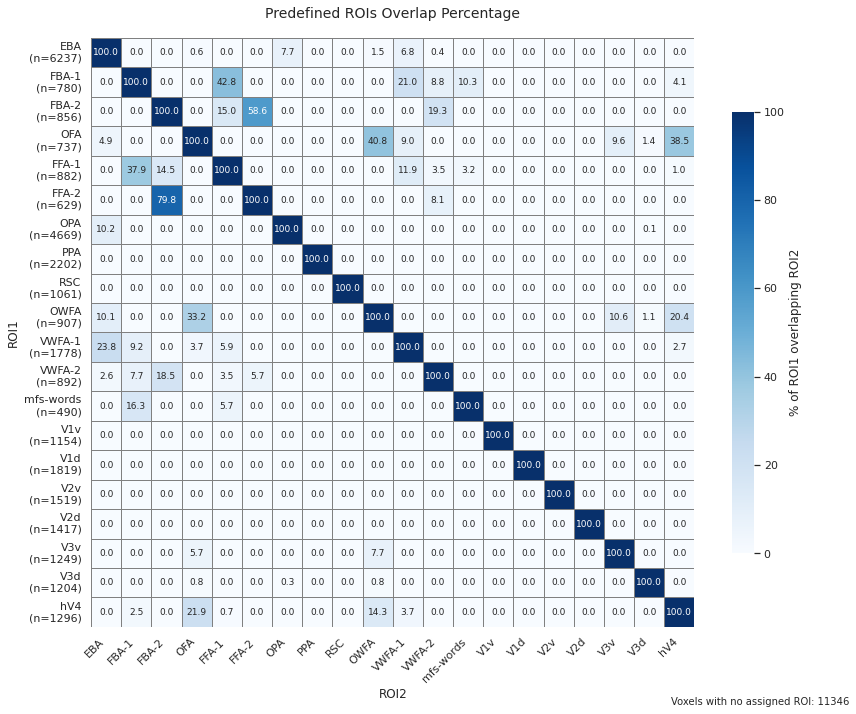

In [7]:
subject = 1

# Getting ROI indices

ROIs_bodies = ['EBA', 'FBA-1', 'FBA-2', 'mTL-bodies']
ROIs_faces = ['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces']
ROIs_places = ['OPA', 'PPA', 'RSC']
ROIs_words = ['OWFA', 'VWFA-1', 'VWFA-2', 'mfs-words', 'mTL-words']
ROIs_visual = ['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']

ROI_names = ROIs_bodies + ROIs_faces + ROIs_places + ROIs_words + ROIs_visual

predefined_ROI_indices = {}

# Creating a dictionary of ROI indices (iterating over copy because we remove ROIs that don't exist)
for ROI in ROI_names.copy():
    
    roi_indices = get_roi_indices(subject, ROI)
    
    if roi_indices is None:
        ROI_names.remove(ROI)
    else:
        predefined_ROI_indices[ROI] = roi_indices
        # print(ROI, roi_indices.shape)
predefined_ROIless_indeices = summary_roi_coverage(predefined_ROI_indices, sub_indices)
plot_ROI_overlap_heatmap_percentage(predefined_ROI_indices, 'Predefined ROIs Overlap Percentage', predefined_ROIless_indeices.shape[0])

# Compare ROI inferring methods
## Old Inferring


Summary of ROI coverage:
Total number of voxels: 39548
Total number of voxels in ROIs: 31778
Unique voxels in ROIs: 13733
Duplicities in ROIs: 18045
Voxels not in any ROI: 25815


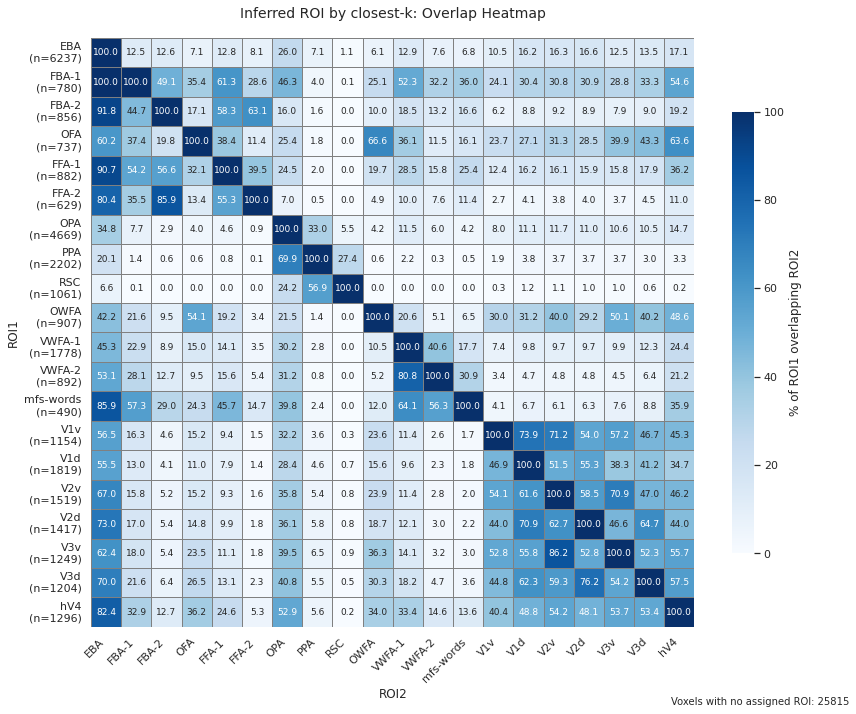

In [8]:
inferred_topk_roi_indices = {}
for ROI in ROI_names:
    size = predefined_ROI_indices[ROI].shape[0]
    if size > 0:
        inferred_topk_roi_indices[ROI] = infer_by_center_of_mass(predefined_ROI_indices[ROI], voxel_embeddings, top_k=size)

# for ROI, indices in inferred_by_size_roi_indices.items():
#     print(f"ROI: {ROI}, inferred indices: {indices.shape[0]} (predefined amount: {predefined_ROI_indices[ROI].shape[0]})")

inferred_ROIless_indices_topk = summary_roi_coverage(inferred_topk_roi_indices, sub_indices)
plot_ROI_overlap_heatmap_percentage(inferred_topk_roi_indices,
                                    title='Inferred ROI by closest-k: Overlap Heatmap',
                                    ROIless_indices_amount=inferred_ROIless_indices_topk.shape[0])

## New inferring


Using top_k 6237 for ROI EBA
Using top_k 780 for ROI FBA-1
Using top_k 856 for ROI FBA-2
Using top_k 737 for ROI OFA
Using top_k 882 for ROI FFA-1
Using top_k 629 for ROI FFA-2
Using top_k 4669 for ROI OPA
Using top_k 2202 for ROI PPA
Using top_k 1061 for ROI RSC
Using top_k 907 for ROI OWFA
Using top_k 1778 for ROI VWFA-1
Using top_k 892 for ROI VWFA-2
Using top_k 490 for ROI mfs-words
Using top_k 1154 for ROI V1v
Using top_k 1819 for ROI V1d
Using top_k 1519 for ROI V2v
Using top_k 1417 for ROI V2d
Using top_k 1249 for ROI V3v
Using top_k 1204 for ROI V3d
Using top_k 1296 for ROI hV4

Summary of ROI coverage:
Total number of voxels: 39548
Total number of voxels in ROIs: 31778
Unique voxels in ROIs: 13733
Duplicities in ROIs: 18045
Voxels not in any ROI: 25815


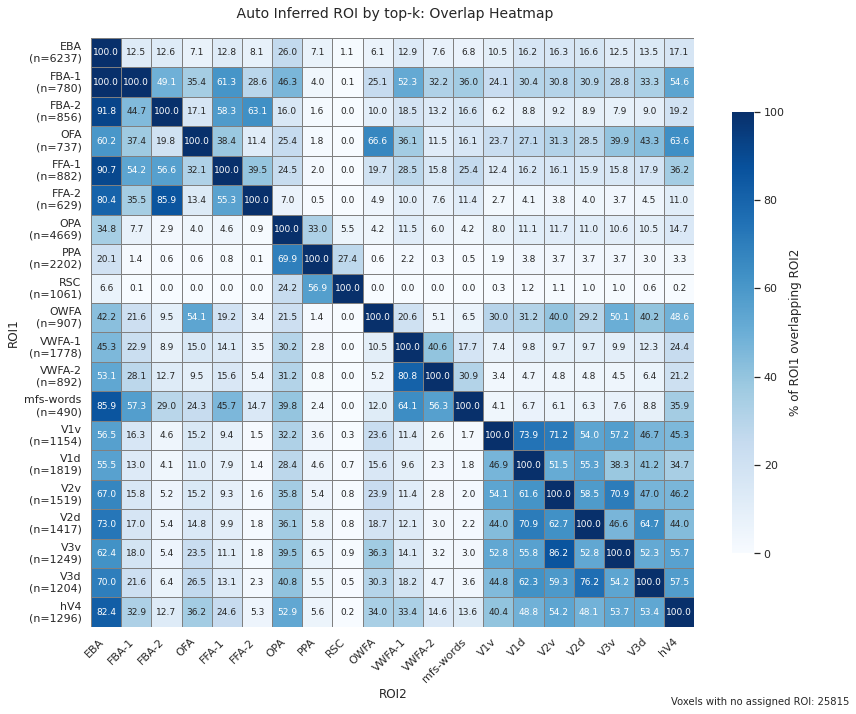

In [9]:
# Now let's try the new method
top_k_dict = {roi_name: len(predefined_ROI_indices[roi_name]) for roi_name in predefined_ROI_indices.keys()}
inferr_config_top_k = ROIInferenceConfig(
    center_method='mean', metric='euclidean', discrimination_method='top_k', top_k_dict=top_k_dict)
inferred_topk_roi_indices_auto = infer_roi_dict(voxel_embeddings, predefined_ROI_indices, config=inferr_config_top_k)
inferred_ROIless_indices_auto = summary_roi_coverage(inferred_topk_roi_indices_auto, sub_indices)
plot_ROI_overlap_heatmap_percentage(inferred_topk_roi_indices_auto,
                                    title=' Auto Inferred ROI by top-k: Overlap Heatmap',
                                    ROIless_indices_amount=inferred_ROIless_indices_auto.shape[0])

In [10]:
def compare_roi_dicts(roi_dict1, roi_dict2):
    # This functoin is to see that the automation works correctly
    if len(roi_dict1) != len(roi_dict2):
        print("ROI dictionaries have different lengths.")
        print(f'ROI dict 1 keys: {list(roi_dict1.keys())}')
        print(f'ROI dict 2 keys: {list(roi_dict2.keys())}')

    # check all ROIs in dict1 are in dict2
    roi1_names = set(roi_dict1.keys())
    roi2_names = set(roi_dict2.keys())
    if roi1_names.symmetric_difference(roi2_names):
        print("Some ROIs in dict1 are not in dict2 or vice versa.")
        print(f'ROIs in dict1 but not in dict2: {roi1_names - roi2_names}')
        print(f'ROIs in dict2 but not in dict1: {roi2_names - roi1_names}')
        return False
    for roi_name in roi1_names:
        print('ROI name:', roi_name)
        indices1 = roi_dict1[roi_name]
        indices2 = roi_dict2[roi_name]
        
        indices1_set = set(indices1)
        indices2_set = set(indices2)
        if indices1_set != indices2_set:
            print(f"Indices for ROI '{roi_name}' differ between dictionaries.")
            print(f"Indices in dict1: {indices1_set}")
            print(f"Indices in dict2: {indices2_set}")
            return False
    return True

In [11]:
compare_roi_dicts(inferred_topk_roi_indices_auto, inferred_topk_roi_indices)


ROI name: PPA
ROI name: V1v
ROI name: V2v
ROI name: FFA-1
ROI name: FBA-2
ROI name: EBA
ROI name: OWFA
ROI name: hV4
ROI name: V2d
ROI name: V3v
ROI name: FBA-1
ROI name: OPA
ROI name: OFA
ROI name: FFA-2
ROI name: VWFA-1
ROI name: VWFA-2
ROI name: mfs-words
ROI name: V3d
ROI name: RSC
ROI name: V1d


True

# Now compare top-k with angle
## Older Version


Summary of ROI coverage:
Total number of voxels: 39548
Total number of voxels in ROIs: 31778
Unique voxels in ROIs: 21192
Duplicities in ROIs: 10586
Voxels not in any ROI: 18356


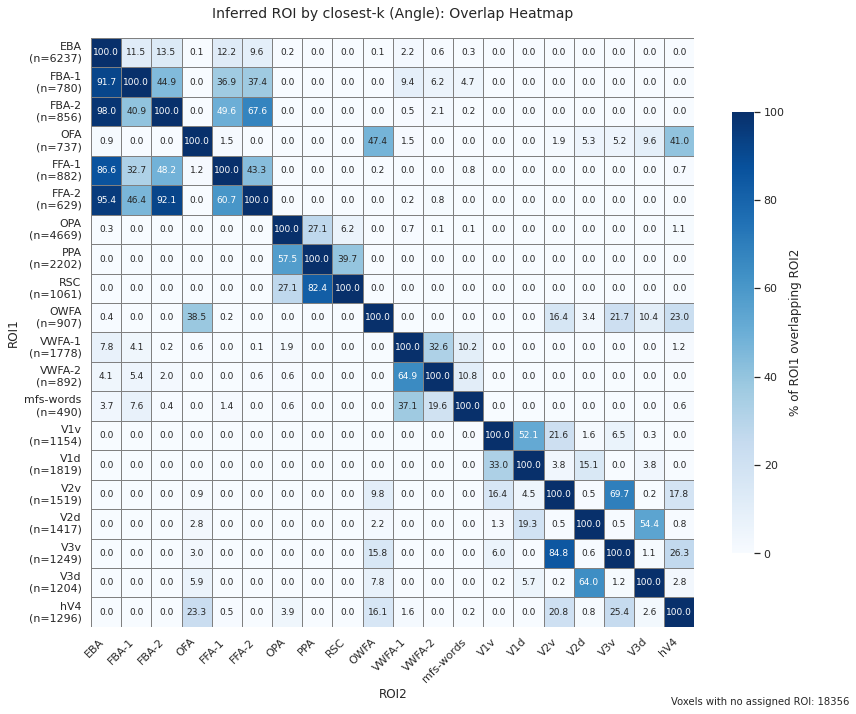

In [12]:
inferred_angle_topk_roi_indices = {}
for ROI in ROI_names:
    size = predefined_ROI_indices[ROI].shape[0]
    if size > 0:
        inferred_angle_topk_roi_indices[ROI] = infer_by_center_of_mass(predefined_ROI_indices[ROI], voxel_embeddings, top_k=size, use_angle=True)

# for ROI, indices in inferred_by_size_roi_indices.items():
#     print(f"ROI: {ROI}, inferred indices: {indices.shape[0]} (predefined amount: {predefined_ROI_indices[ROI].shape[0]})")

inferred_angle_ROIless_indices = summary_roi_coverage(inferred_angle_topk_roi_indices, sub_indices)
plot_ROI_overlap_heatmap_percentage(inferred_angle_topk_roi_indices,
                                    title='Inferred ROI by closest-k (Angle): Overlap Heatmap',
                                    ROIless_indices_amount=inferred_angle_ROIless_indices.shape[0])


Using top_k 6237 for ROI EBA
Using top_k 780 for ROI FBA-1
Using top_k 856 for ROI FBA-2
Using top_k 737 for ROI OFA
Using top_k 882 for ROI FFA-1
Using top_k 629 for ROI FFA-2
Using top_k 4669 for ROI OPA
Using top_k 2202 for ROI PPA
Using top_k 1061 for ROI RSC
Using top_k 907 for ROI OWFA
Using top_k 1778 for ROI VWFA-1
Using top_k 892 for ROI VWFA-2
Using top_k 490 for ROI mfs-words
Using top_k 1154 for ROI V1v
Using top_k 1819 for ROI V1d
Using top_k 1519 for ROI V2v
Using top_k 1417 for ROI V2d
Using top_k 1249 for ROI V3v
Using top_k 1204 for ROI V3d
Using top_k 1296 for ROI hV4

Summary of ROI coverage:
Total number of voxels: 39548
Total number of voxels in ROIs: 31778
Unique voxels in ROIs: 21192
Duplicities in ROIs: 10586
Voxels not in any ROI: 18356


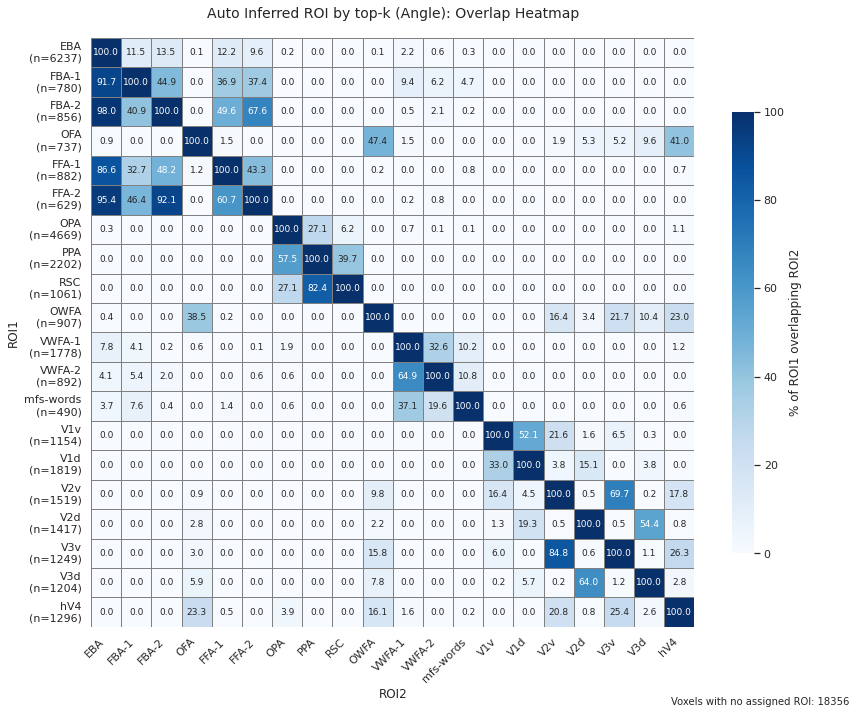

In [13]:
inferred_angle_topk_roi_indices_auto = {}
top_k_dict_angle = {roi_name: len(predefined_ROI_indices[roi_name]) for roi_name in predefined_ROI_indices.keys()}
inferr_config = ROIInferenceConfig(
    center_method='mean', metric='cosine', discrimination_method='top_k', top_k_dict=top_k_dict_angle)
inferred_angle_topk_roi_indices_auto = infer_roi_dict(voxel_embeddings, predefined_ROI_indices, config=inferr_config)
inferred_angle_ROIless_indices_auto = summary_roi_coverage(inferred_angle_topk_roi_indices_auto, sub_indices)
plot_ROI_overlap_heatmap_percentage(inferred_angle_topk_roi_indices_auto,
                                    title='Auto Inferred ROI by top-k (Angle): Overlap Heatmap',
                                    ROIless_indices_amount=inferred_angle_ROIless_indices_auto.shape[0])

In [14]:
compare_roi_dicts(inferred_topk_roi_indices_auto, inferred_topk_roi_indices)

ROI name: PPA
ROI name: V1v
ROI name: V2v
ROI name: FFA-1
ROI name: FBA-2
ROI name: EBA
ROI name: OWFA
ROI name: hV4
ROI name: V2d
ROI name: V3v
ROI name: FBA-1
ROI name: OPA
ROI name: OFA
ROI name: FFA-2
ROI name: VWFA-1
ROI name: VWFA-2
ROI name: mfs-words
ROI name: V3d
ROI name: RSC
ROI name: V1d


True


Summary of ROI coverage:
Total number of voxels: 39548
Total number of voxels in ROIs: 603489
Unique voxels in ROIs: 39545
Duplicities in ROIs: 563944
Voxels not in any ROI: 3


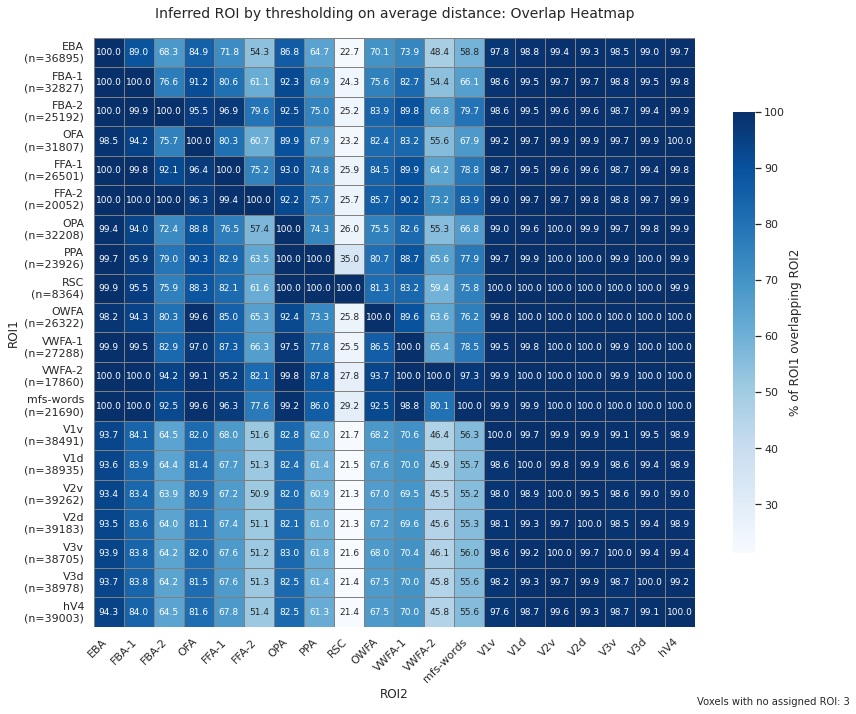

In [15]:
avg_dist_roi_indices = {}
for ROI in ROI_names:
    avg_dist_from_center_of_mass = get_average_distance(predefined_ROI_indices[ROI], voxel_embeddings, center_point=voxel_embeddings[predefined_ROI_indices[ROI]])
    avg_dist_roi_indices[ROI] = infer_by_center_of_mass(predefined_ROI_indices[ROI], voxel_embeddings, 
                                                        threshold=avg_dist_from_center_of_mass, top_k=None)


avg_dist_ROIless_indices = summary_roi_coverage(avg_dist_roi_indices, sub_indices)
plot_ROI_overlap_heatmap_percentage(avg_dist_roi_indices,
                                    title='Inferred ROI by thresholding on average distance: Overlap Heatmap',
                                    ROIless_indices_amount=avg_dist_ROIless_indices.shape[0])


Using threshold 0.9313753843307495 for ROI EBA
Using threshold 0.8523856997489929 for ROI FBA-1
Using threshold 0.8482763171195984 for ROI FBA-2
Using threshold 0.8769943714141846 for ROI OFA
Using threshold 0.8261610865592957 for ROI FFA-1
Using threshold 0.8238385915756226 for ROI FFA-2
Using threshold 0.8706161379814148 for ROI OPA
Using threshold 0.8097355365753174 for ROI PPA
Using threshold 0.691980242729187 for ROI RSC
Using threshold 0.8335867524147034 for ROI OWFA
Using threshold 0.8363380432128906 for ROI VWFA-1
Using threshold 0.7521945238113403 for ROI VWFA-2
Using threshold 0.7764235138893127 for ROI mfs-words
Using threshold 0.9788257479667664 for ROI V1v
Using threshold 0.9991030097007751 for ROI V1d
Using threshold 0.978001594543457 for ROI V2v
Using threshold 0.9954902529716492 for ROI V2d
Using threshold 0.9488447904586792 for ROI V3v
Using threshold 0.9695935249328613 for ROI V3d
Using threshold 0.9530482292175293 for ROI hV4

Summary of ROI coverage:
Total number of

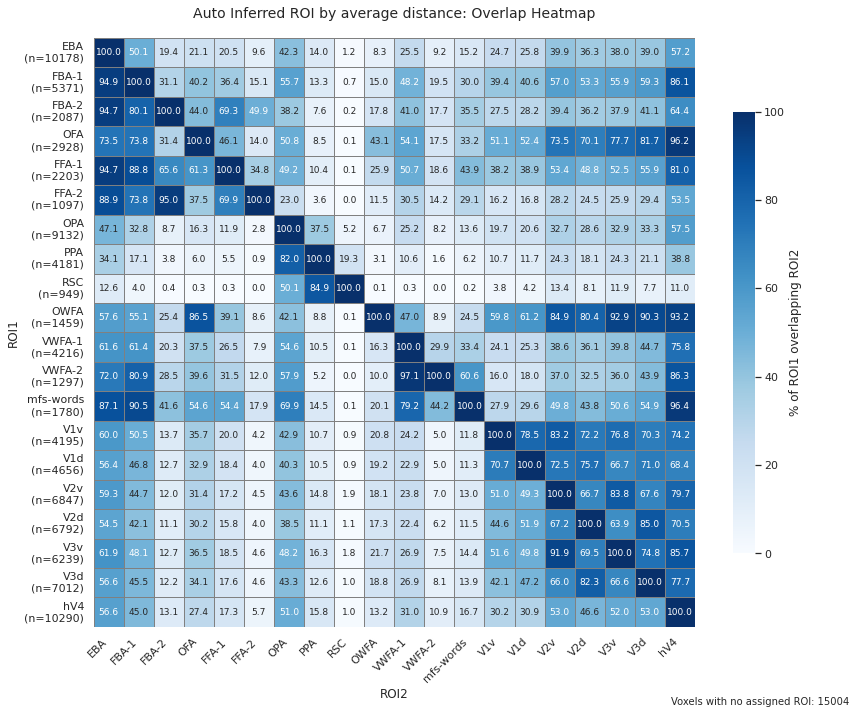

In [16]:
centers = infer_centers(voxel_embeddings, predefined_ROI_indices, center_method='mean')
threshold_dict = {roi_name: get_average_distance(predefined_ROI_indices[roi_name], voxel_embeddings, center_point=centers[roi_name]) for roi_name in predefined_ROI_indices.keys()}
inferr_config_avg_dist = ROIInferenceConfig(
    center_method='mean', metric='euclidean', discrimination_method='threshold', threshold_dict=threshold_dict)
avg_dist_roi_indices_auto = infer_roi_dict(voxel_embeddings, predefined_ROI_indices, config=inferr_config_avg_dist)
avg_dist_ROIless_indices_auto = summary_roi_coverage(avg_dist_roi_indices_auto, sub_indices)
plot_ROI_overlap_heatmap_percentage(avg_dist_roi_indices_auto,
                                    title='Auto Inferred ROI by average distance: Overlap Heatmap',
                                    ROIless_indices_amount=avg_dist_ROIless_indices_auto.shape[0])

In [17]:
compare_roi_dicts(inferred_topk_roi_indices_auto, inferred_topk_roi_indices)

ROI name: PPA
ROI name: V1v
ROI name: V2v
ROI name: FFA-1
ROI name: FBA-2
ROI name: EBA
ROI name: OWFA
ROI name: hV4
ROI name: V2d
ROI name: V3v
ROI name: FBA-1
ROI name: OPA
ROI name: OFA
ROI name: FFA-2
ROI name: VWFA-1
ROI name: VWFA-2
ROI name: mfs-words
ROI name: V3d
ROI name: RSC
ROI name: V1d


True


Summary of ROI coverage:
Total number of voxels: 39548
Total number of voxels in ROIs: 36547
Unique voxels in ROIs: 21546
Duplicities in ROIs: 15001
Voxels not in any ROI: 18002


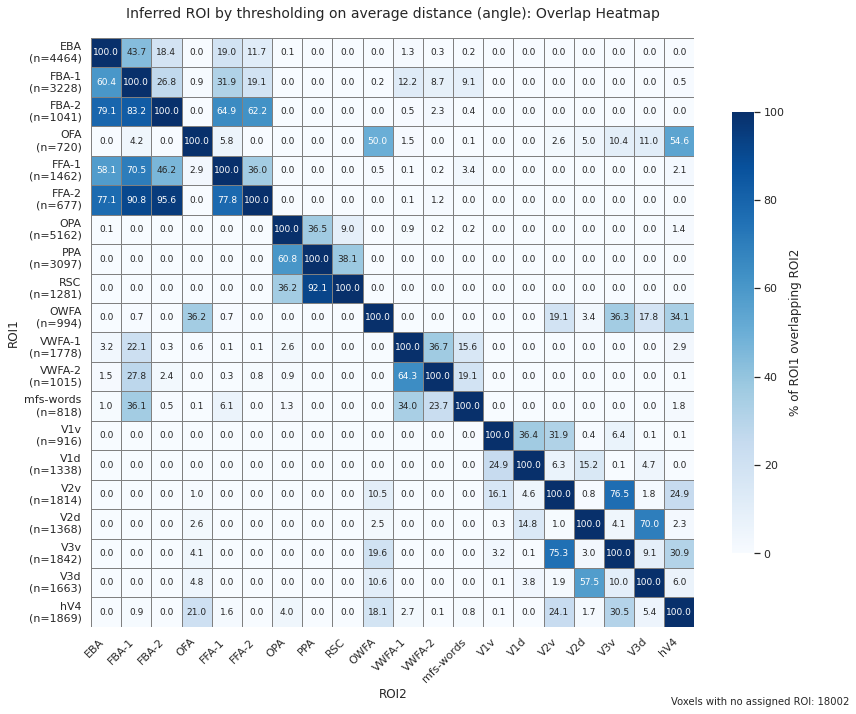

In [18]:
avg_dist_angle_roi_indices = {}
centers = infer_centers(voxel_embeddings=voxel_embeddings, predefined_ROI_indices_dict=predefined_ROI_indices, center_method='mean')
for ROI in ROI_names:
    avg_dist_from_center_of_mass = get_average_distance(predefined_ROI_indices[ROI], voxel_embeddings, center_point=centers[ROI], metric='cosine')
    avg_dist_angle_roi_indices[ROI] = infer_by_center_of_mass(predefined_ROI_indices[ROI], voxel_embeddings,
                                                        threshold=avg_dist_from_center_of_mass, top_k=None, use_angle=True)


avg_dist_angle_ROIless_indices = summary_roi_coverage(avg_dist_angle_roi_indices, sub_indices)
plot_ROI_overlap_heatmap_percentage(avg_dist_angle_roi_indices,
                                    title='Inferred ROI by thresholding on average distance (angle): Overlap Heatmap',
                                    ROIless_indices_amount=avg_dist_angle_ROIless_indices.shape[0])


Using threshold 0.5844517946243286 for ROI EBA
Using threshold 0.6023611426353455 for ROI FBA-1
Using threshold 0.47456878423690796 for ROI FBA-2
Using threshold 0.4858267307281494 for ROI OFA
Using threshold 0.5184286236763 for ROI FFA-1
Using threshold 0.43115440011024475 for ROI FFA-2
Using threshold 0.5460930466651917 for ROI OPA
Using threshold 0.4591570794582367 for ROI PPA
Using threshold 0.3325008153915405 for ROI RSC
Using threshold 0.4513879120349884 for ROI OWFA
Using threshold 0.48595836758613586 for ROI VWFA-1
Using threshold 0.43929076194763184 for ROI VWFA-2
Using threshold 0.4910488426685333 for ROI mfs-words
Using threshold 0.44579198956489563 for ROI V1v
Using threshold 0.4475152790546417 for ROI V1d
Using threshold 0.509856104850769 for ROI V2v
Using threshold 0.49058613181114197 for ROI V2d
Using threshold 0.5160667300224304 for ROI V3v
Using threshold 0.5115624070167542 for ROI V3d
Using threshold 0.6021724939346313 for ROI hV4

Summary of ROI coverage:
Total numbe

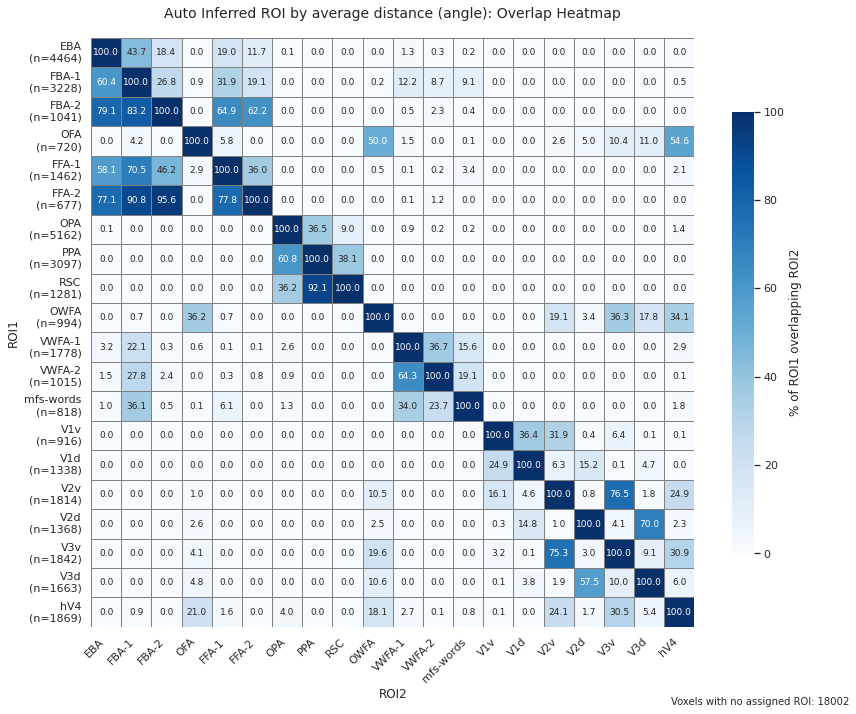

In [19]:
centers = infer_centers(voxel_embeddings=voxel_embeddings, predefined_ROI_indices_dict=predefined_ROI_indices, center_method='mean')
threshold_dict = {roi_name: get_average_distance(predefined_ROI_indices[roi_name], voxel_embeddings, center_point=centers[roi_name], metric='cosine') for roi_name in predefined_ROI_indices.keys()}
config = ROIInferenceConfig(
    center_method='mean', metric='cosine', discrimination_method='threshold', threshold_dict=threshold_dict)
avg_dist_angle_roi_indices_auto = infer_roi_dict(voxel_embeddings, predefined_ROI_indices, config=config)
avg_dist_angle_ROIless_indices_auto = summary_roi_coverage(avg_dist_angle_roi_indices_auto, sub_indices)
plot_ROI_overlap_heatmap_percentage(avg_dist_angle_roi_indices_auto,
                                    title='Auto Inferred ROI by average distance (angle): Overlap Heatmap',
                                    ROIless_indices_amount=avg_dist_angle_ROIless_indices_auto.shape[0])

In [20]:
compare_roi_dicts(avg_dist_angle_roi_indices_auto, avg_dist_angle_roi_indices)

ROI name: PPA
ROI name: V1v
ROI name: V2v
ROI name: FFA-1
ROI name: FBA-2
ROI name: EBA
ROI name: OWFA
ROI name: hV4
ROI name: V2d
ROI name: V3v
ROI name: FBA-1
ROI name: OPA
ROI name: OFA
ROI name: FFA-2
ROI name: VWFA-1
ROI name: VWFA-2
ROI name: mfs-words
ROI name: V3d
ROI name: RSC
ROI name: V1d


True

# Now let's check the meanshift one...
## Older verison:

In [21]:
meanshift_center_dict = {}

predefined_ROI_indices = {}
print("Hello, this is a test for meanshift center inference.")
# Creating a dictionary of ROI indices (iterating over copy because we remove ROIs that don't exist)
for ROI in ROI_names.copy():
    
    roi_indices = get_roi_indices(subject, ROI)
    
    if roi_indices is None:
        ROI_names.remove(ROI)
        print(f"ROI {ROI} does not exist for subject {1}. Removing from list.")

    else:
        predefined_ROI_indices[ROI] = roi_indices

    meanshift_center_dict[ROI] = ROI_actions.infer_center_by_meanshift(roi_indices, voxel_embeddings)
    # print(f"{ROI} center shape: {tuple(center_dict[ROI].shape)}")
labels, meanshift_roi_indices = ROI_actions.assign_voxels_to_rois(voxel_embeddings, meanshift_center_dict, ROI_names)




Hello, this is a test for meanshift center inference.



Summary of ROI coverage:
Total number of voxels: 39548
Total number of voxels in ROIs: 39548
Unique voxels in ROIs: 39548
Duplicities in ROIs: 0
Voxels not in any ROI: 0


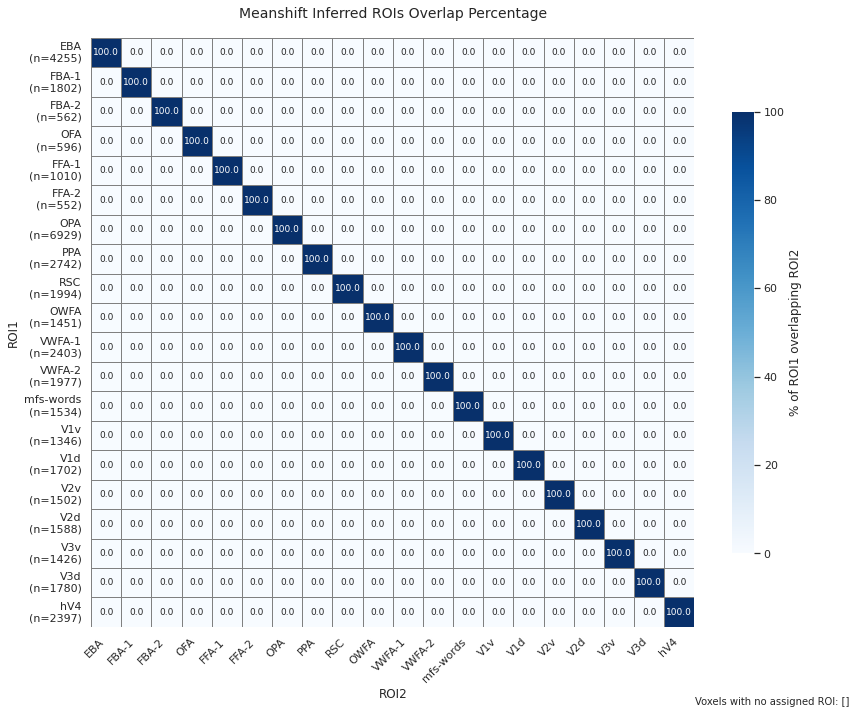

In [22]:
roiless_indices = summary_roi_coverage(meanshift_roi_indices, sub_indices)
plot_ROI_overlap_heatmap_percentage(meanshift_roi_indices, 'Meanshift Inferred ROIs Overlap Percentage',
                                    ROIless_indices_amount=roiless_indices)


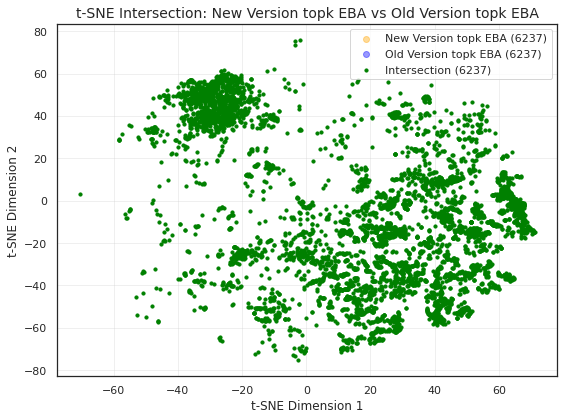

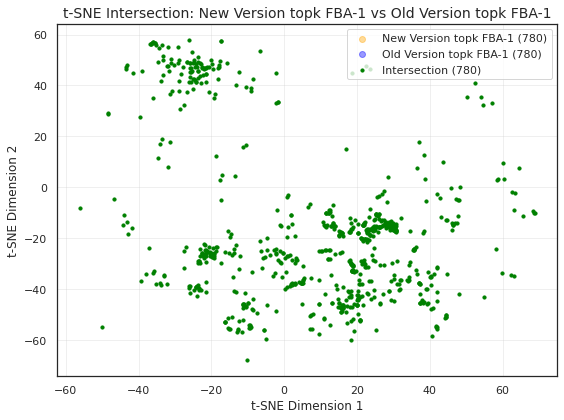

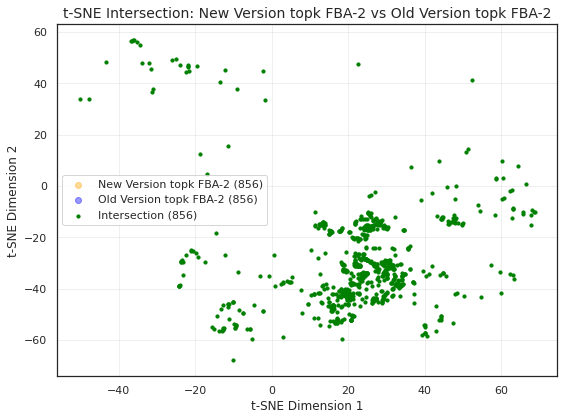

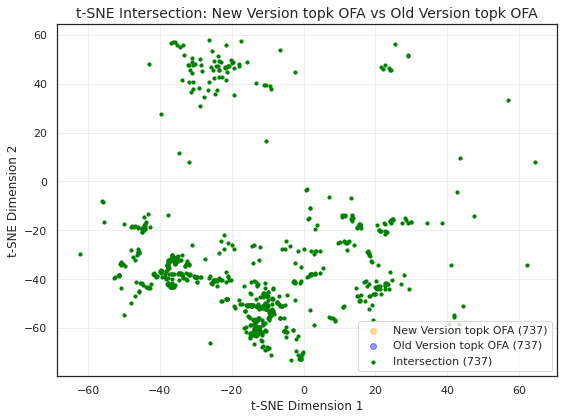

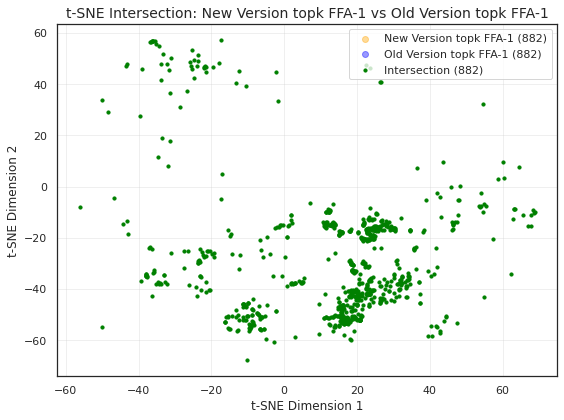

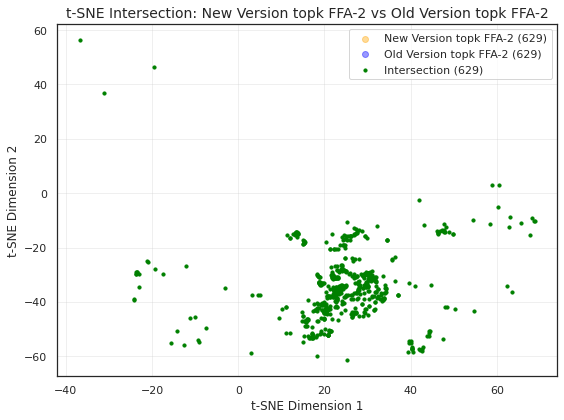

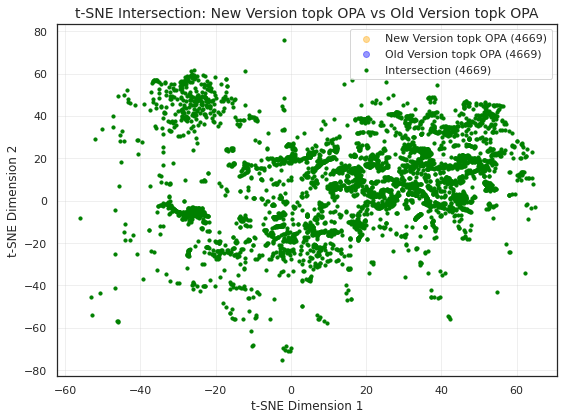

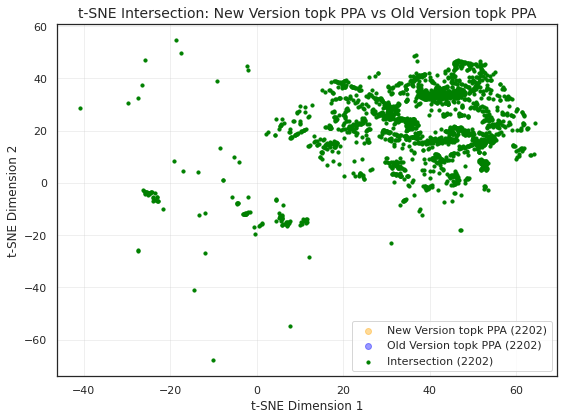

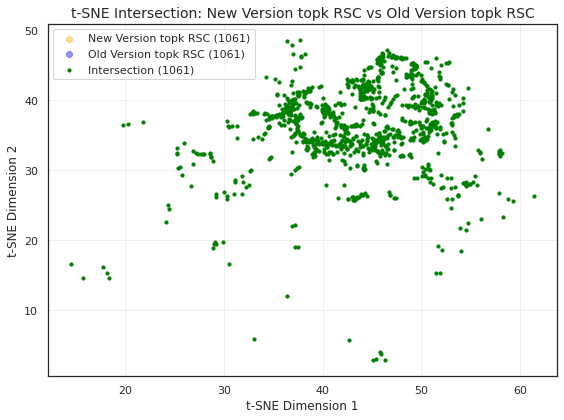

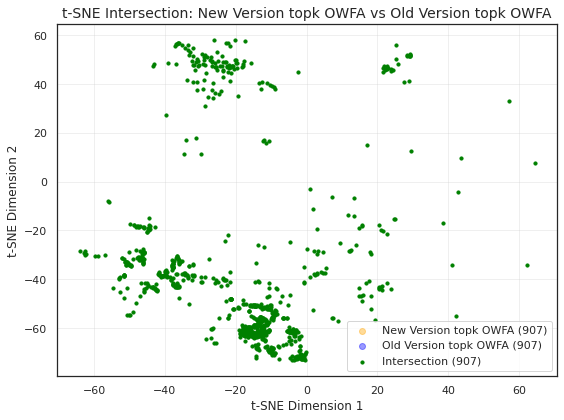

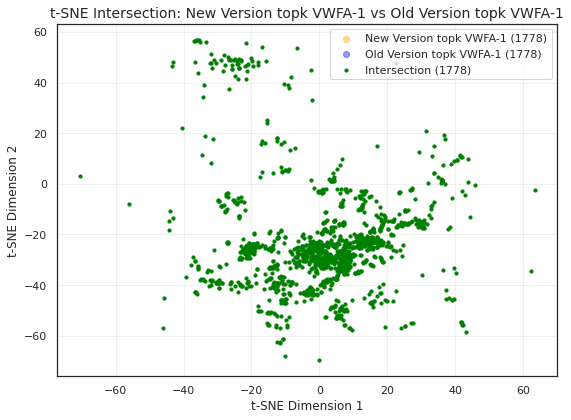

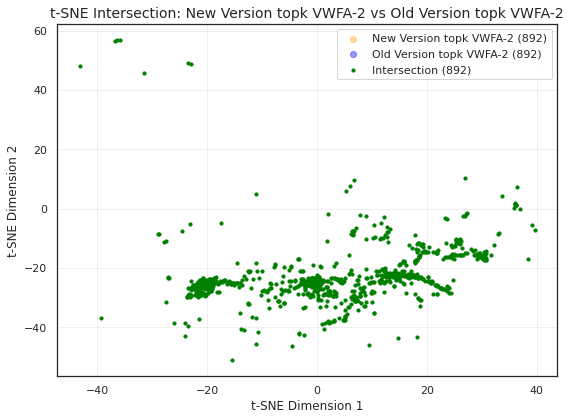

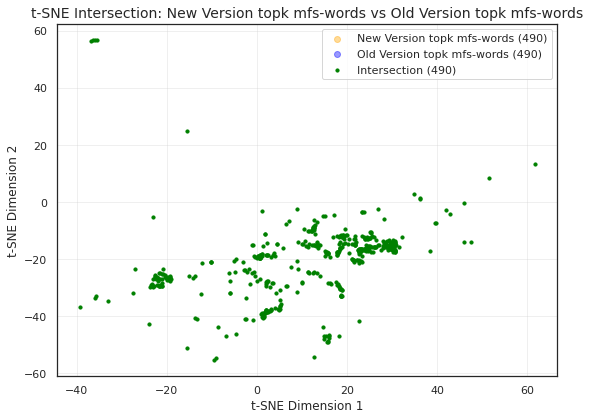

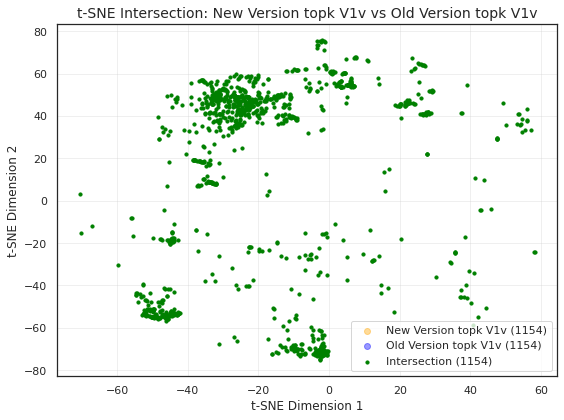

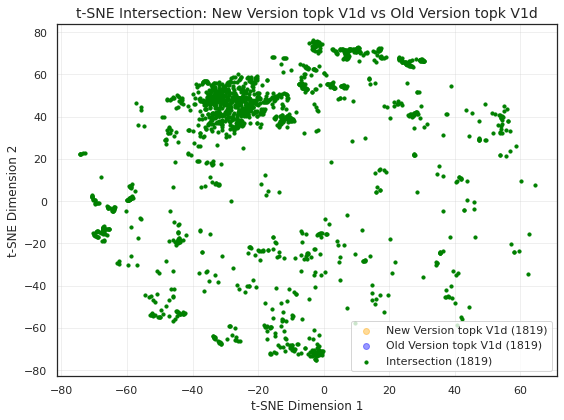

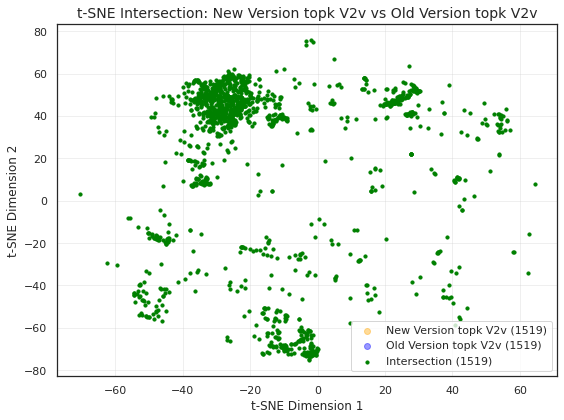

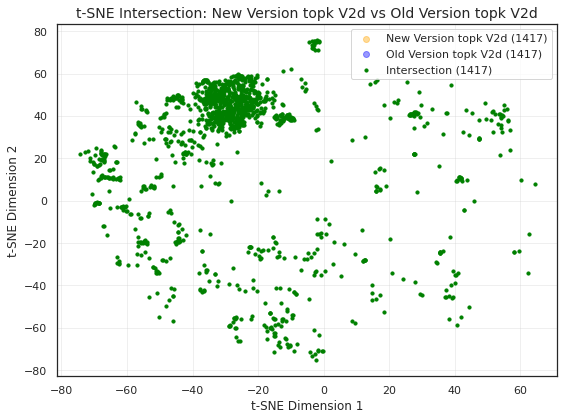

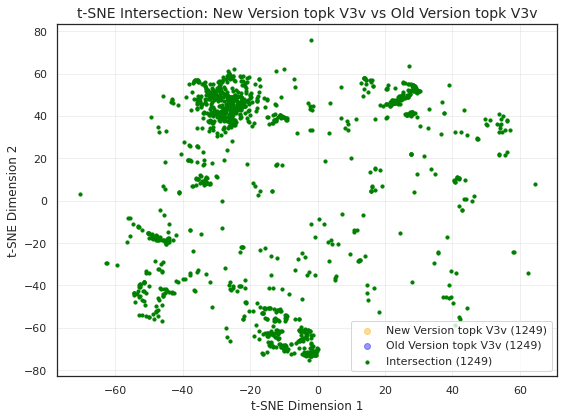

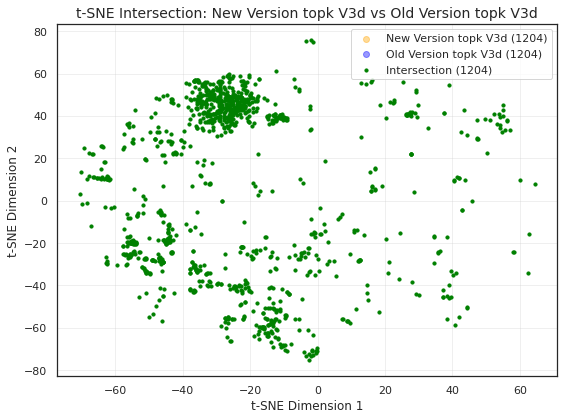

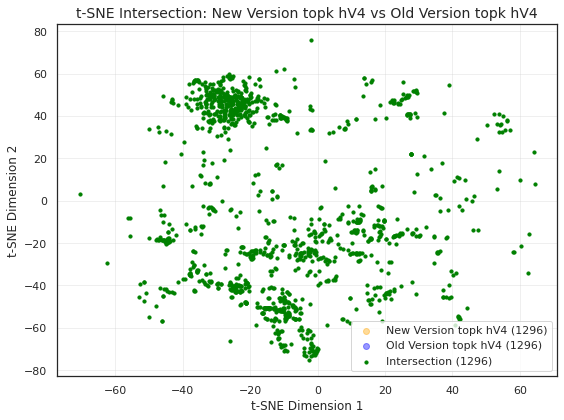

In [23]:
for ROI in ROI_names:
    plot_roi_intersection_tsne(inferred_topk_roi_indices_auto[ROI], f'New Version topk {ROI}', inferred_topk_roi_indices[ROI], f'Old Version topk {ROI}', voxel_embeddings_tsne)